In [48]:
from IPython.display import display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")
from fancyimpute import KNN
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, StratifiedKFold,train_test_split
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier,RandomForestClassifier
from IPython.display import display, HTML
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
df= pd.read_csv('loan_default.csv')


## Part 1: Data Cleaning

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14867 entries, 0 to 14866
Data columns (total 35 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Unnamed: 0                 14867 non-null  int64  
 1   ID                         14867 non-null  int64  
 2   year                       14867 non-null  int64  
 3   loan_limit                 14534 non-null  object 
 4   Gender                     14867 non-null  object 
 5   approv_in_adv              14787 non-null  object 
 6   loan_type                  14867 non-null  object 
 7   loan_purpose               14853 non-null  object 
 8   Credit_Worthiness          14867 non-null  object 
 9   open_credit                14867 non-null  object 
 10  business_or_commercial     14867 non-null  object 
 11  loan_amount                14867 non-null  int64  
 12  rate_of_interest           11228 non-null  float64
 13  Interest_rate_spread       11203 non-null  flo

Separating categorical and continuous features for preprocessing. Turning categorical into strings to count for NaNs in categorical data. Missing categorical features can also predict default outcome and allows for missing continues features to be imputed. 

In [50]:
cat=[]
cont=[]
for i in list(df.columns)[2:]:
    if df[i].dtype=='object' or i=='year':
        df[i]=df[i].apply(lambda x: str(x))
        cat.append(i)    
    else:
        if i=='Status':
            pass
        else:
            cont.append(i)



In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14867 entries, 0 to 14866
Data columns (total 35 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Unnamed: 0                 14867 non-null  int64  
 1   ID                         14867 non-null  int64  
 2   year                       14867 non-null  object 
 3   loan_limit                 14867 non-null  object 
 4   Gender                     14867 non-null  object 
 5   approv_in_adv              14867 non-null  object 
 6   loan_type                  14867 non-null  object 
 7   loan_purpose               14867 non-null  object 
 8   Credit_Worthiness          14867 non-null  object 
 9   open_credit                14867 non-null  object 
 10  business_or_commercial     14867 non-null  object 
 11  loan_amount                14867 non-null  int64  
 12  rate_of_interest           11228 non-null  float64
 13  Interest_rate_spread       11203 non-null  flo

Since Interest Rate Spread is not connected to the default outcome, I will omit it from my analysis. However, it is important to keep an eye on it and revisit the data once it is updated. 

In [52]:
for i in cont:
    print (df.groupby(['Status']).agg({i: 'mean'}).T.reset_index())


Status        index             0              1
0       loan_amount  335653.79809  321377.183406
Status             index         0       1
0       rate_of_interest  4.049116  4.1872
Status                 index         0   1
0       Interest_rate_spread  0.443051 NaN
Status            index            0        1
0       Upfront_charges  3207.443178  1332.82
Status index           0           1
0       term  335.773888  334.427089
Status           index              0              1
0       property_value  507270.731054  452981.498612
Status   index            0            1
0       income  7201.140882  6053.095844
Status         index           0          1
0       Credit_Score  697.851825  701.31441
Status index          0          1
0        LTV  72.661739  75.653281
Status  index         0          1
0       dtir1  37.43762  39.630211


In [53]:
cont.remove('Interest_rate_spread')

Continues features included in the analysis

In [54]:
df[cont].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14867 entries, 0 to 14866
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   loan_amount       14867 non-null  int64  
 1   rate_of_interest  11228 non-null  float64
 2   Upfront_charges   10919 non-null  float64
 3   term              14860 non-null  float64
 4   property_value    13365 non-null  float64
 5   income            13950 non-null  float64
 6   Credit_Score      14867 non-null  int64  
 7   LTV               13365 non-null  float64
 8   dtir1             12459 non-null  float64
dtypes: float64(7), int64(2)
memory usage: 1.0 MB


Even though year does not predict the outcome, I will keep it because future data will include data from 2020 and 202, and the risk of default will be higher in 2020 and 2021 so year will become an important predictor.


In [55]:
for i in cat:
    df1=df.groupby(['Status',i]).agg({'ID': 'count'})
    df2= df1.groupby(level=0).apply(lambda x:100 * x / float(x.sum())).reset_index()
    print (df2)

   Status  year     ID
0       0  2019  100.0
1       1  2019  100.0
   Status loan_limit         ID
0       0         cf  92.269928
1       0        nan   2.115505
2       0        ncf   5.614568
3       1         cf  88.591703
4       1        nan   2.620087
5       1        ncf   8.788210
   Status             Gender         ID
0       0             Female  18.200482
1       0              Joint  29.501027
2       0               Male  28.590556
3       0  Sex Not Available  23.707935
4       1             Female  19.104803
5       1              Joint  20.414847
6       1               Male  30.567686
7       1  Sex Not Available  29.912664
   Status approv_in_adv         ID
0       0           nan   0.535571
1       0         nopre  83.834687
2       0           pre  15.629742
3       1           nan   0.545852
4       1         nopre  85.425764
5       1           pre  14.028384
   Status loan_type         ID
0       0     type1  77.925556
1       0     type2  12.514505
2       0

Categorical features included in the analysis

In [56]:
df[cat].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14867 entries, 0 to 14866
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   year                       14867 non-null  object
 1   loan_limit                 14867 non-null  object
 2   Gender                     14867 non-null  object
 3   approv_in_adv              14867 non-null  object
 4   loan_type                  14867 non-null  object
 5   loan_purpose               14867 non-null  object
 6   Credit_Worthiness          14867 non-null  object
 7   open_credit                14867 non-null  object
 8   business_or_commercial     14867 non-null  object
 9   Neg_ammortization          14867 non-null  object
 10  interest_only              14867 non-null  object
 11  lump_sum_payment           14867 non-null  object
 12  construction_type          14867 non-null  object
 13  occupancy_type             14867 non-null  object
 14  Secure

Transforming features into a matrix or vectors 

In [57]:
cat_matrix = OneHotEncoder().fit_transform(df[cat]).toarray()
ohe=OneHotEncoder().fit(df[cat])
new_columns=[]
new_columns=ohe.get_feature_names(cat)
df_cat=pd.DataFrame(cat_matrix, columns=new_columns)
cont_matrix=StandardScaler().fit_transform(df[cont])
df_cont=pd.DataFrame(cont_matrix, columns=[cont])
df_combined = pd.concat([df_cont, df_cat], axis=1)

Imputing  missing continues data. I am using KNN but more complex imputation techniques should be explored as they can potentially increase accuracy of the model even more.

In [59]:
knn_imputer = KNN()
matrix_imputed = knn_imputer.fit_transform(df_combined)

Imputing row 1/14867 with 0 missing, elapsed time: 64.808
Imputing row 101/14867 with 0 missing, elapsed time: 64.810
Imputing row 201/14867 with 0 missing, elapsed time: 64.811
Imputing row 301/14867 with 0 missing, elapsed time: 64.813
Imputing row 401/14867 with 0 missing, elapsed time: 64.815
Imputing row 501/14867 with 0 missing, elapsed time: 64.817
Imputing row 601/14867 with 0 missing, elapsed time: 64.818
Imputing row 701/14867 with 2 missing, elapsed time: 64.819
Imputing row 801/14867 with 0 missing, elapsed time: 64.822
Imputing row 901/14867 with 0 missing, elapsed time: 64.823
Imputing row 1001/14867 with 0 missing, elapsed time: 64.824
Imputing row 1101/14867 with 0 missing, elapsed time: 64.826
Imputing row 1201/14867 with 0 missing, elapsed time: 64.828
Imputing row 1301/14867 with 0 missing, elapsed time: 64.830
Imputing row 1401/14867 with 0 missing, elapsed time: 64.831
Imputing row 1501/14867 with 0 missing, elapsed time: 64.832
Imputing row 1601/14867 with 0 missi

Imputing row 13901/14867 with 5 missing, elapsed time: 65.669
Imputing row 14001/14867 with 2 missing, elapsed time: 65.699
Imputing row 14101/14867 with 2 missing, elapsed time: 65.727
Imputing row 14201/14867 with 5 missing, elapsed time: 65.753
Imputing row 14301/14867 with 2 missing, elapsed time: 65.778
Imputing row 14401/14867 with 5 missing, elapsed time: 65.802
Imputing row 14501/14867 with 5 missing, elapsed time: 65.827
Imputing row 14601/14867 with 2 missing, elapsed time: 65.852
Imputing row 14701/14867 with 5 missing, elapsed time: 65.876
Imputing row 14801/14867 with 2 missing, elapsed time: 65.901


## Part 2: Building the Model

In [60]:
X=pd.DataFrame(matrix_imputed, columns=df_combined.columns)
y=df['Status'].values

Random Forest Score:	0.877 ± 0.007
Ada Boost Score:	0.896 ± 0.01
Gradient Boosting Score:	0.961 ± 0.006

Feature Weights:


,Random Forest,Ada Boost,Gradient Boosting
credit_type_EQUI,0.495554,0.02,0.161024
"(rate_of_interest,)",0.333638,0.64,0.096970
"(dtir1,)",0.036302,0.04,0.067645
"(Upfront_charges,)",0.030560,0.06,0.089889
"(LTV,)",0.021823,0.04,0.058370
Neg_ammortization_not_neg,0.016988,0.02,0.011609
"(income,)",0.016272,0.04,0.058652
loan_type_type1,0.012034,0.00,0.005898
lump_sum_payment_lpsm,0.007767,0.00,0.009998
lump_sum_payment_not_lpsm,0.004917,0.02,0.008549


None


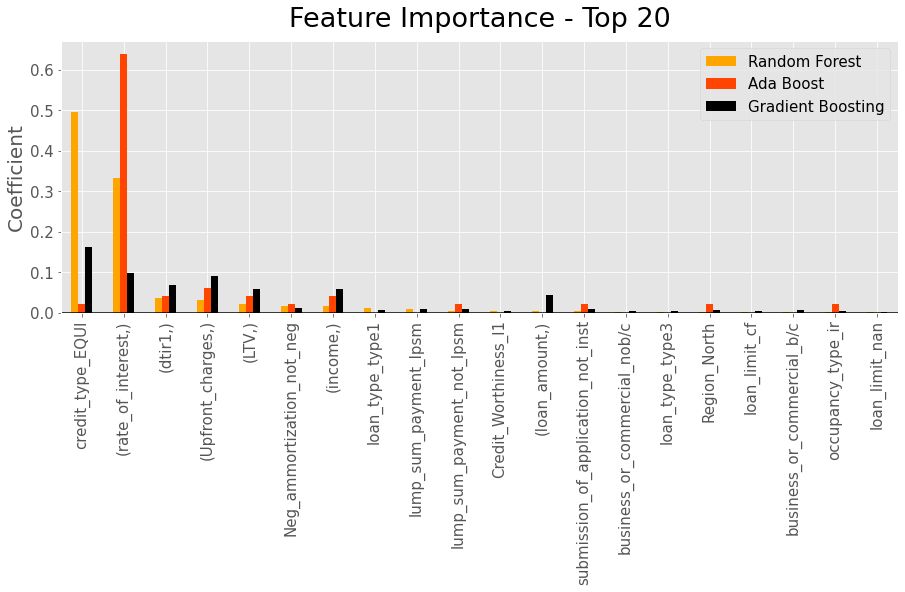

Time used 7.70s


In [68]:
from time import time
start = time()

plt.style.use('ggplot')

X_train, X_test, y_train, y_test = train_test_split(X,\
                                                    y,train_size=0.7,random_state=1,stratify=y)

rf = RandomForestClassifier(random_state=10,class_weight = 'balanced')
abc = AdaBoostClassifier(random_state=10)
gbc = GradientBoostingClassifier(random_state=10)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=78)
def score(model, name):
    s = cross_val_score(model, X_train, y_train, cv=cv, n_jobs=-1)
    print ("{} Score:\t{:0.3} ± {:0.3}".format(name, s.mean().round(3), s.std().round(3)))


score(rf,"Random Forest")
score(abc, "Ada Boost")
score(gbc, "Gradient Boosting")


rf.fit(X_train, y_train)
abc.fit(X_train, y_train)
gbc.fit(X_train, y_train)


importances = pd.DataFrame(list(zip(gbc.feature_importances_,
                               abc.feature_importances_,
                               rf.feature_importances_,
                              )),
                           index=X_train.columns,
                           columns=['Random Forest',
                                    'Ada Boost',
                                    'Gradient Boosting',
                                   ]).sort_values('Random Forest',
                                                                 ascending=False)

print ()
print ('\033[1m'+'Feature Weights:'+'\033[0m')
print (display(importances.head(30)))



importances[0:20].plot(kind='bar', figsize=(15,5), color=['orange','orangered','black'])


plt.title('Feature Importance - Top 20', fontsize = 27, y = 1.03, color='black')


plt.ylabel('Coefficient', fontsize = 20)
plt.yticks(fontsize = 15)
plt.axhline(0, color='black')
plt.xticks(rotation=90, fontsize = 15)
plt.legend(fontsize = 15)
plt.show()
print('Time used {:.2f}s'.format(time()-start))

In [63]:
y_pred=gbc.predict(X_test)
test_acc = accuracy_score(y_true=y_test, y_pred=y_pred)
matrix_clf = np.array(confusion_matrix(y_test, gbc.predict(X_test)))
confusion_clf = pd.DataFrame(matrix_clf, index=['No Default','Default'],\
                     columns=['No Default','Default'])
print('Test Accuracy: %.2f%%' % (100 * test_acc))
print ('')
print (classification_report(y_test, y_pred))



Test Accuracy: 95.61%

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      3362
           1       0.99      0.83      0.90      1099

    accuracy                           0.96      4461
   macro avg       0.97      0.91      0.94      4461
weighted avg       0.96      0.96      0.95      4461



Due to imbalanced outcome (more consumers do not default on their loans than the ones who default), the recall for the default outcome is on the lower side. I will use synthetic oversampling technique to combat the imbalanced outcome and to increase default recall. Then I will rerun the model with the synthetic sample and test it on my original test sample. 

In [89]:
from imblearn.over_sampling import SMOTE
sm = SMOTE()
X_resampled, y_resampled = sm.fit_resample(X, y)




Random Forest SMOT Score:	0.93 ± 0.005
Ada Boost SMOT Score:	0.888 ± 0.004
Gradient Boosting SMOT Score:	0.967 ± 0.003

Feature Weights:


,Random Forest SMOT,Ada Boost SMOT,Gradient Boosting SMOT
credit_type_EQUI,0.434745,0.02,0.155958
"(rate_of_interest,)",0.303159,0.42,0.081299
"(Upfront_charges,)",0.068047,0.06,0.077330
"(dtir1,)",0.039574,0.06,0.053755
submission_of_application_not_inst,0.015420,0.02,0.013269
Neg_ammortization_not_neg,0.014827,0.02,0.013827
Neg_ammortization_neg_amm,0.014630,0.00,0.014749
credit_type_CRIF,0.010907,0.00,0.042166
age_55-64,0.010830,0.04,0.011817
"(LTV,)",0.010778,0.04,0.042442


None


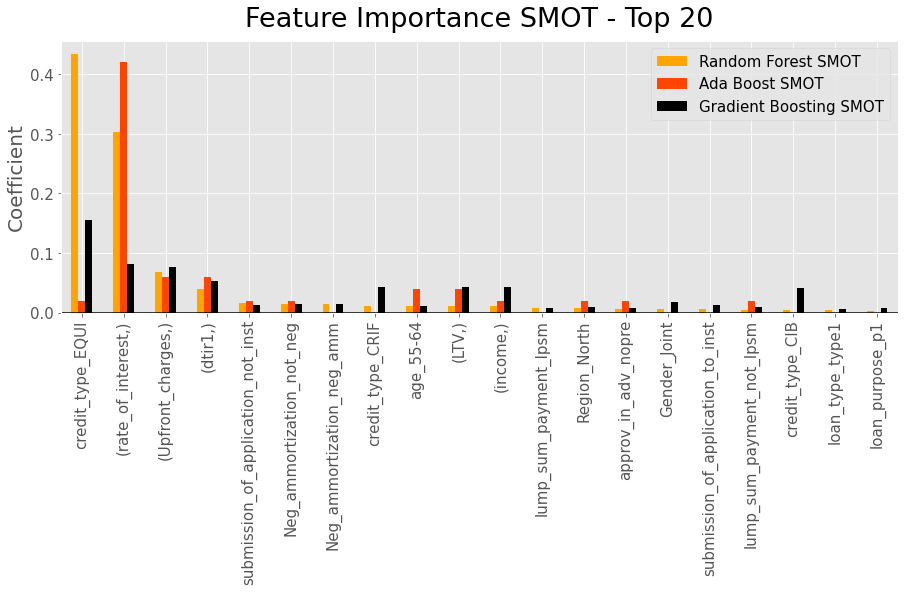

Time used 15.31s


In [90]:
from time import time
start = time()

plt.style.use('ggplot')

X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X_resampled,\
                                                    y_resampled,train_size=0.7,random_state=1,stratify=y_resampled)

rf_smote = RandomForestClassifier(random_state=10,class_weight = 'balanced')
abc_smote = AdaBoostClassifier(random_state=10)
gbc_smote = GradientBoostingClassifier(random_state=10)

cv_smote = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)
def score(model, name):
    s = cross_val_score(model, X_train_smote, y_train_smote, cv=cv_smote, n_jobs=-1)
    print ("{} Score:\t{:0.3} ± {:0.3}".format(name, s.mean().round(3), s.std().round(3)))


print ()
score(rf_smote,"Random Forest SMOT")
score(abc_smote, "Ada Boost SMOT")
score(gbc_smote, "Gradient Boosting SMOT")


rf_smote.fit(X_train_smote, y_train_smote)
abc_smote.fit(X_train_smote, y_train_smote)
gbc_smote.fit(X_train_smote, y_train_smote)


importances = pd.DataFrame(list(zip(gbc_smote.feature_importances_,
                               abc_smote.feature_importances_,
                               rf_smote.feature_importances_,
                              )),
                           index=X_train.columns,
                           columns=['Random Forest SMOT',
                                    'Ada Boost SMOT',
                                    'Gradient Boosting SMOT',
                                   ]).sort_values('Random Forest SMOT',
                                                                 ascending=False)


print ()
print ('\033[1m'+'Feature Weights:'+'\033[0m')
print (display(importances.head(30)))

importances[0:20].plot(kind='bar', figsize=(15,5), color=['orange','orangered','black'])
plt.title('Feature Importance SMOT - Top 20', fontsize = 27, y = 1.03, color='black')
plt.ylabel('Coefficient', fontsize = 20)
plt.yticks(fontsize = 15)
plt.axhline(0, color='black')
plt.xticks(rotation=90, fontsize = 15)
plt.legend(fontsize = 15)
plt.show()

print('Time used {:.2f}s'.format(time()-start))

In [118]:
y_pred_test_smote=gbc_smote.predict(X_test)

test_acc = accuracy_score(y_true=y_test, y_pred=y_pred_test_smote)
matrix_clf_smote = np.array(confusion_matrix(y_test, rf_smote.predict(X_test)))
confusion_clf_smote = pd.DataFrame(matrix_clf_smote, index=['No Default','Default'],\
                     columns=['No Default','Default'])
print('Test Accuracy: %.2f%%' % (100 * test_acc))
print ('')
print (classification_report(y_test, y_pred_test_smote))

Test Accuracy: 96.14%

              precision    recall  f1-score   support

           0       0.96      0.99      0.97      3362
           1       0.96      0.88      0.92      1099

    accuracy                           0.96      4461
   macro avg       0.96      0.93      0.95      4461
weighted avg       0.96      0.96      0.96      4461



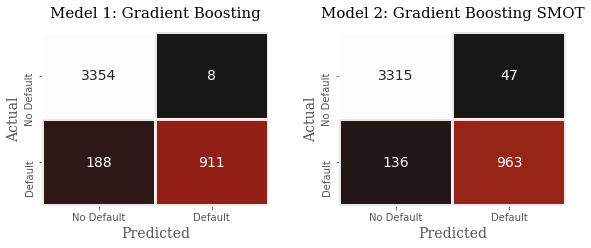

In [124]:
# from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

plt.style.use(['ggplot'])

fig, axes = plt.subplots(1,2, figsize=(8,3))
plt.tight_layout(w_pad=4.0)


sns.heatmap(confusion_clf, annot=True, annot_kws={"size": 14},cmap="afmhot",fmt='g', cbar=False,linewidths=2,ax=axes[0], alpha=.9)
axes[0].set_ylabel('Actual', fontsize=14,family='serif')
axes[0].set_xlabel('Predicted', fontsize=14,family='serif')
axes[0].set_title("Medel 1: Gradient Boosting", fontsize=15, y=1.05,family='serif')

sns.heatmap(confusion_clf_smote, annot=True, annot_kws={"size": 14},cmap="afmhot",fmt='g', cbar=False,linewidths=2,ax=axes[1], alpha=.9)
axes[1].set_ylabel('Actual', fontsize=14,family='serif')
axes[1].set_xlabel('Predicted', fontsize=14,family='serif')
axes[1].set_title("Model 2: Gradient Boosting SMOT", fontsize=15, y=1.05,family='serif')

plt.show()

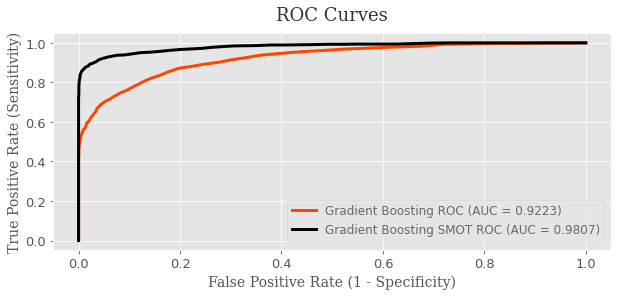

In [120]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc


plt.style.use('ggplot')

plt.figure(figsize=(10,4))

y_pred_clf = rf.predict_proba(X_test)[:,1]
y_pred_clf_smote = rf_smote.predict_proba(X_test)[:,1]


fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_clf)
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test,y_pred_clf_smote)


ROC_AUC = auc(fpr, tpr)
ROC_AUC1 = auc(fpr1, tpr1)


plt.plot(fpr, tpr, label='Gradient Boosting ROC (AUC = %0.4f)' % ROC_AUC,color='orangered', linewidth=3)
plt.plot(fpr1, tpr1, label='Gradient Boosting SMOT ROC (AUC = %0.4f)' % ROC_AUC1, color='black',linewidth=3)


# plt.xlim([-0.05, 1.05])
# plt.ylim([-0.05, 1.05])
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=14,family='serif')
plt.ylabel('True Positive Rate (Sensitivity)',fontsize=14,family='serif')


l=plt.legend(loc='lower right', fontsize=12,bbox_to_anchor=(1, 0.015))
for text in l.get_texts():
    text.set_color("dimgray")

plt.title('ROC Curves', color="black", alpha=0.8,fontsize=18, y=1.03,family='serif')
plt.show()

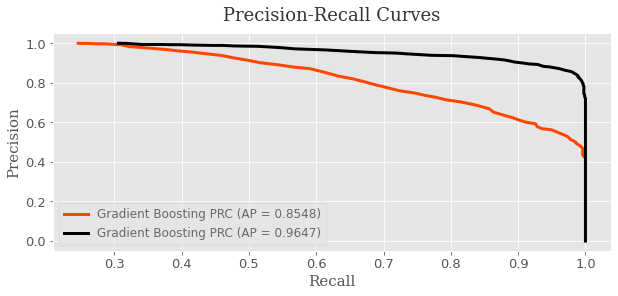

In [121]:
from sklearn.metrics import average_precision_score

plt.style.use('ggplot')

plt.figure(figsize=(10,4))

y_pred_clf = rf.predict_proba(X_test)[:,1]
y_pred_clf_smote = rf_smote.predict_proba(X_test)[:,1]

precision, tpr, thresholds = metrics.precision_recall_curve(y_test, y_pred_clf)
precision1, tpr1, thresholds1 = metrics.precision_recall_curve(y_test,y_pred_clf_smote)

average_precision=average_precision_score(y_test, y_pred_clf)
average_precision1=average_precision_score(y_test,y_pred_clf_smote)

plt.plot(precision, tpr, label='Gradient Boosting PRC (AP = %0.4f)' % average_precision,color='orangered', linewidth=3)
plt.plot(precision1, tpr1, label='Gradient Boosting PRC (AP = %0.4f)' % average_precision1, color='black',linewidth=3)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
l=plt.legend(loc='lower left', fontsize=12)
for text in l.get_texts():
    text.set_color("dimgray")

plt.xlabel('Recall', fontsize=15,family='serif')
plt.ylabel('Precision',fontsize=15,family='serif')
plt.title('Precision-Recall Curves', color="black", alpha=0.8,fontsize=18, y=1.03,family='serif')
plt.show()   

## Part 3: Data Visualization of Top Predictors 

In [122]:
df=pd.read_csv('loan_default.csv')

df['Status']=df['Status'].map({1:'Default',0:'No Default'})
df['Region'] = df['Region'].str.title()

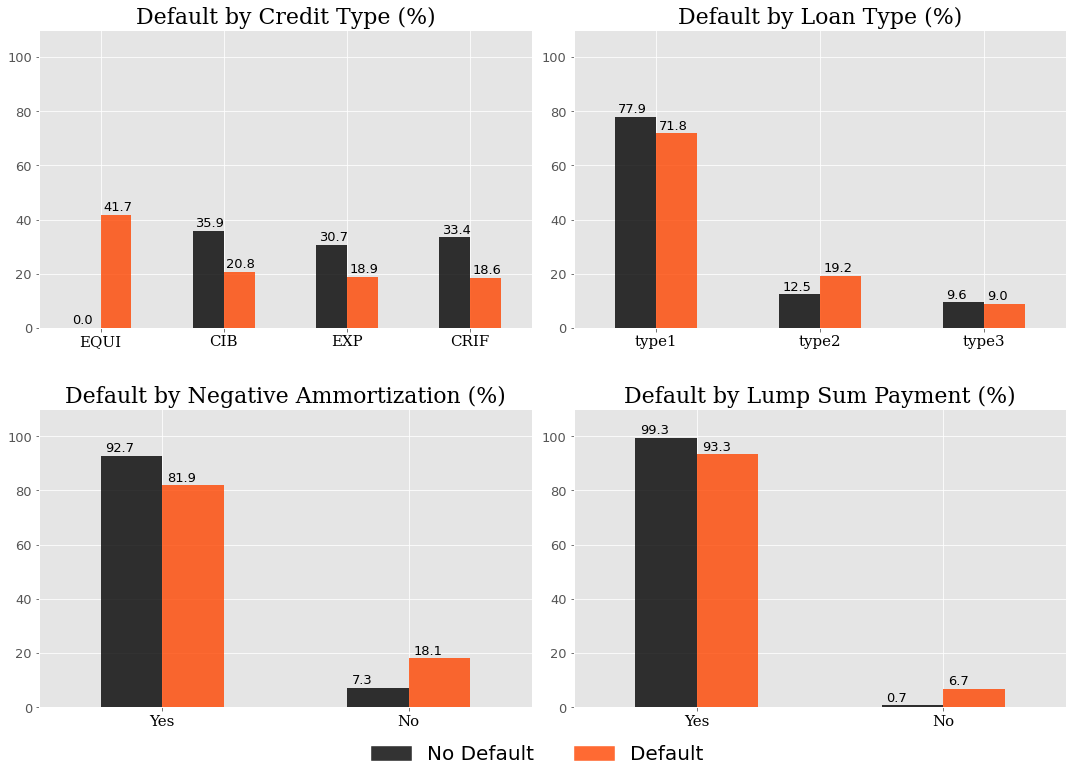

In [123]:
plt.style.use('ggplot')

fig, axes = plt.subplots(nrows=2,ncols=2, figsize=(15,10))
plt.tight_layout(h_pad=6)
cat=['credit_type','loan_type','Neg_ammortization','lump_sum_payment']
titles=['Credit Type','Loan Type',\
        'Negative Ammortization','Lump Sum Payment']

for ax,feature, title in zip(axes.flat,cat, titles):
    df1=df.groupby(['Status',feature]).agg({'ID': 'count'})
    df2= df1.groupby(level=0).apply(lambda x:100 * x / float(x.sum())).reset_index()
    df3=pd.pivot_table(df2, index=['Status'], values=['ID'], \
                   columns=feature,aggfunc='mean').T.reset_index().iloc[:,1:].\
                   sort_values(by='Default',ascending=False)
    df3[['No Default','Default']].plot(kind='bar',
               color=['black','orangered'],\
                              fontsize=13, alpha=.8, ax=ax)
    leg=ax.legend().set_visible(False)
    ax.set_title('Default by '+ title +' (%)' ,fontsize=22,family='serif')
    ax.set_ylim([0,110])
    for i in ax.patches:
            ax.text( i.get_x()+.02,i.get_height()+1.5, \
                '{:.1f}'.format(i.get_height()), fontsize=13)
    if feature=='credit_type':
        ax.set_xticklabels(df3[feature],size =15,family='serif', \
                       color='black', rotation='horizontal')
        
    if feature=='loan_type':
        ax.set_xticklabels(df3[feature],size =15,family='serif', \
                       color='black', rotation='horizontal')
    
    if feature in['lump_sum_payment','Neg_ammortization']:
        ax.set_xticklabels(['Yes','No'],size =15,family='serif', \
                       color='black', rotation='horizontal')


leg=ax.legend(['No Default','Default'],  ncol=2,loc='lower right', \
          fontsize=12,prop={'size':20},bbox_to_anchor=(.30, -.25))
leg.legendHandles[1].set_color('orangered')
leg.legendHandles[0].set_color('black')
leg.get_frame().set_facecolor('none')
leg.get_frame().set_edgecolor('none')

plt.show()


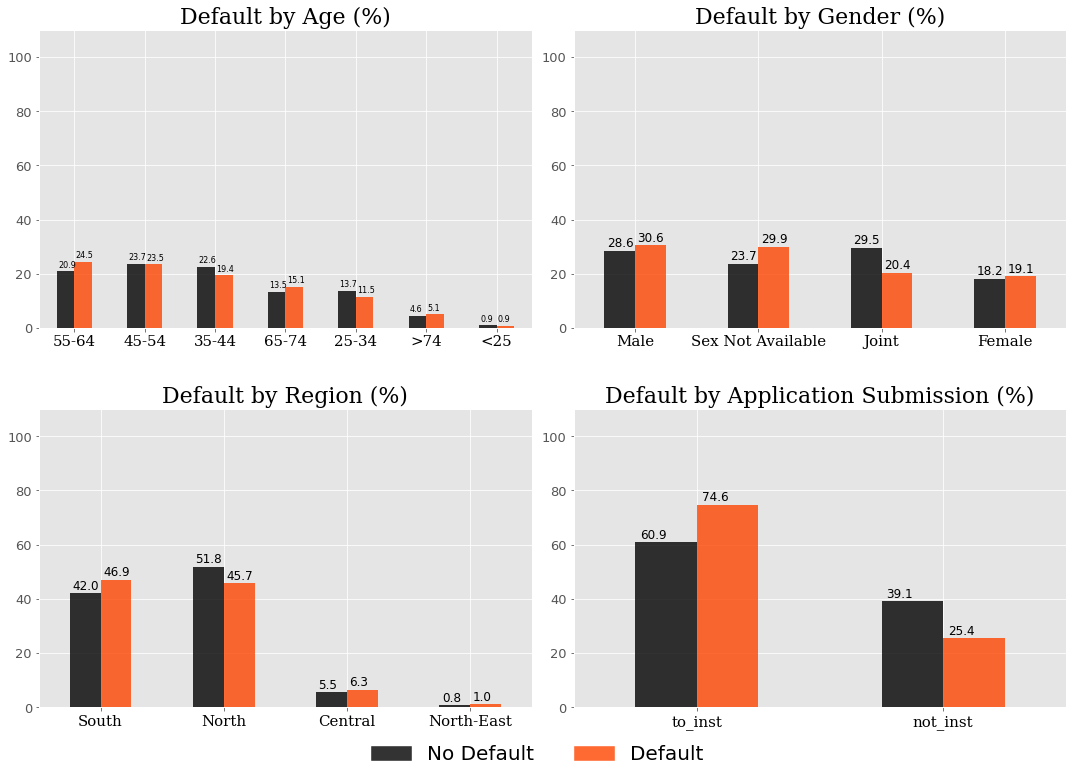

In [114]:
plt.style.use('ggplot')

fig, axes = plt.subplots(nrows=2,ncols=2, figsize=(15,10))
plt.tight_layout(h_pad=6)
cat=['age','Gender','Region','submission_of_application']
titles=['Age','Gender',\
        'Region','Application Submission']

for ax,feature, title in zip(axes.flat,cat, titles):
    df1=df.groupby(['Status',feature]).agg({'ID': 'count'})
    df2= df1.groupby(level=0).apply(lambda x:100 * x / float(x.sum())).reset_index()
    df3=pd.pivot_table(df2, index=['Status'], values=['ID'], \
                   columns=feature,aggfunc='mean').T.reset_index().iloc[:,1:].\
                   sort_values(by='Default',ascending=False)
    df3[['No Default','Default']].plot(kind='bar',
               color=['black','orangered'],\
                              fontsize=13, alpha=.8, ax=ax)
    leg=ax.legend().set_visible(False)
    ax.set_title('Default by '+ title +' (%)' ,fontsize=22,family='serif')
    ax.set_ylim([0,110])
    if feature=='age':
        for i in ax.patches:
            ax.text( i.get_x()+.02,i.get_height()+1.5, \
                '{:.1f}'.format(i.get_height()), fontsize=8)
    else:
        for i in ax.patches:
            ax.text( i.get_x()+.02,i.get_height()+1.5, \
                '{:.1f}'.format(i.get_height()), fontsize=12)
    ax.set_xticklabels(df3[feature],size =15,family='serif', \
                       color='black', rotation='horizontal')
        
leg=ax.legend(['No Default','Default'],  ncol=2,loc='lower right', \
          fontsize=12,prop={'size':20},bbox_to_anchor=(.30, -.25))
leg.legendHandles[1].set_color('orangered')
leg.legendHandles[0].set_color('black')
leg.get_frame().set_facecolor('none')
leg.get_frame().set_edgecolor('none')

plt.show()

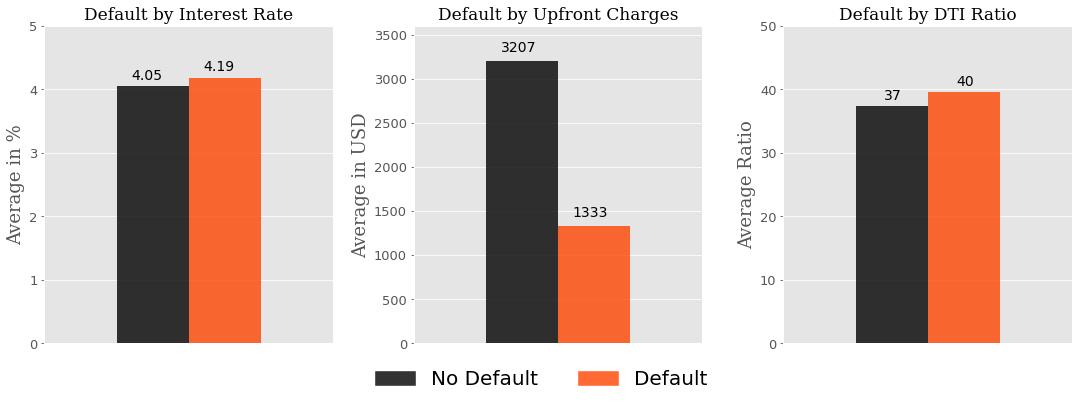

In [115]:
plt.style.use('ggplot')

fig, axes = plt.subplots(ncols=3, figsize=(15,5))
plt.tight_layout(w_pad=5)
cont=['rate_of_interest','Upfront_charges','dtir1']
titles=['Interest Rate','Upfront Charges','DTI Ratio']
for ax,feature, title in zip(axes.flat,cont, titles):
    df0=df.groupby(['Status']).agg({feature: 'mean'}).T.reset_index()
    df0[['No Default','Default']].plot(kind='bar',
               color=['black','orangered'],\
                              fontsize=13, alpha=.8, ax=ax)
    ax.set_xticks([])
    leg=ax.legend().set_visible(False)
    if feature=='rate_of_interest':
        ax.set_ylim([0,5])
        ax.set_ylabel('Average in %',size =18,family='serif')
        
        for i in ax.patches:
            ax.text(i.get_x()+.05,i.get_height()+.1, \
                '{:.2f}'.format(i.get_height()), fontsize=14)
    elif feature=='Upfront_charges':
        ax.set_ylim([0,3600])
        ax.set_ylabel('Average in USD',size =18,family='serif')
        for i in ax.patches:
            ax.text( i.get_x()+.05,i.get_height()+100, \
                '{:.0f}'.format(i.get_height()), fontsize=14)
    else:
        ax.set_ylim([0,50])
        ax.set_ylabel('Average Ratio',size =18,family='serif')
        for i in ax.patches:
            ax.text( i.get_x()+.1,i.get_height()+1, \
                '{:,.0f}'.format(i.get_height()), fontsize=14)
    ax.set_title('Default by '+ title ,fontsize=17,family='serif')
leg=ax.legend(['No Default','Default'],  ncol=2,loc='lower right', \
          fontsize=10,prop={'size':20},bbox_to_anchor=(-.2, -.2))
leg.legendHandles[1].set_color('orangered')
leg.legendHandles[0].set_color('black')
leg.get_frame().set_facecolor('none')
leg.get_frame().set_edgecolor('none')

plt.show()  

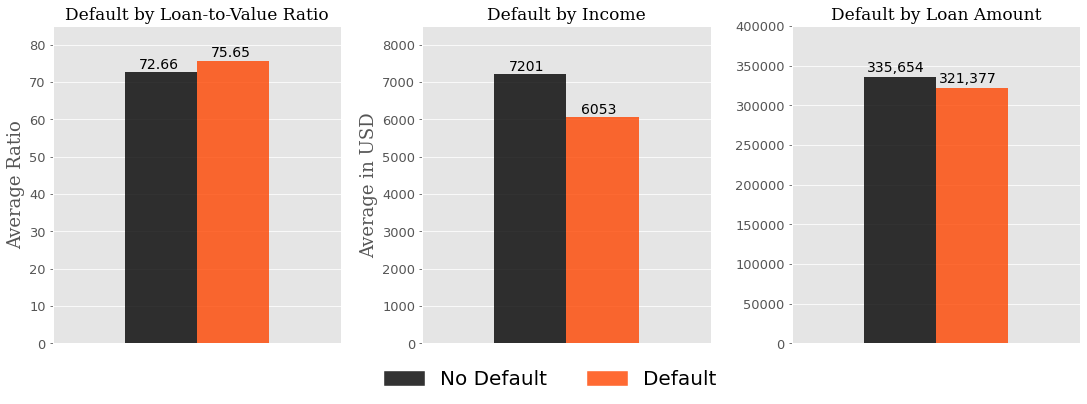

In [116]:
plt.style.use('ggplot')

fig, axes = plt.subplots(ncols=3, figsize=(15,5))
plt.tight_layout(w_pad=5)
cont=['LTV','income','loan_amount']
titles=['Loan-to-Value Ratio','Income','Loan Amount']
for ax,feature, title in zip(axes.flat,cont, titles):
    df0=df.groupby(['Status']).agg({feature: 'mean'}).T.reset_index()
    df0[['No Default','Default']].plot(kind='bar',
               color=['black','orangered'],\
                              fontsize=13, alpha=.8, ax=ax)
    ax.set_xticks([])
    leg=ax.legend().set_visible(False)
    if feature=='LTV':
        ax.set_ylim([0,85])
        ax.set_ylabel('Average Ratio',size =18,family='serif')
        for i in ax.patches:
            ax.text(i.get_x()+.05,i.get_height()+1, \
                '{:.2f}'.format(i.get_height()), fontsize=14)
    elif feature=='income':
        ax.set_ylim([0,8500])
        ax.set_ylabel('Average in USD',size =18,family='serif')
        for i in ax.patches:
            ax.text( i.get_x()+.05,i.get_height()+100, \
                '{:.0f}'.format(i.get_height()), fontsize=14)
    else:
        ax.set_ylim([0,400000])
#         ax.set_ylabel('Average in USD',size =18,family='serif')
        for i in ax.patches:
            ax.text( i.get_x()+.01,i.get_height()+7000, \
                '{:,.0f}'.format(i.get_height()), fontsize=14)
    ax.set_title('Default by '+ title ,fontsize=17,family='serif')
leg=ax.legend(['No Default','Default'],  ncol=2,loc='lower right', \
          fontsize=10,prop={'size':20},bbox_to_anchor=(-.2, -.2))
leg.legendHandles[1].set_color('orangered')
leg.legendHandles[0].set_color('black')
leg.get_frame().set_facecolor('none')
leg.get_frame().set_edgecolor('none')

plt.show() 